# GAM-based fitting with random effects


## Load libraries

In [47]:
import mssm as ms
import warnings
import gamache as gm
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import mssm
from scipy import stats
import numpy as np
import pandas as pd
from numpy.linalg import inv, cholesky
from scipy.linalg import cho_solve


In [55]:
class NegBin(mssm.models.Family):
   """
   Negative Binomial (NB2) Family (Poisson–Gamma mixture).

   We assume: Y_i ~ NB(mu_i, alpha), with Var(Y_i) = mu_i + alpha * mu_i^2.
   Here we use the NB2 parameterization where the dispersion alpha = 1 / size.

   Internally, scipy's nbinom is parameterized by (n, p) with pmf:
       P(Y=k) = C(k+n-1, k) * p^n * (1-p)^k
   and mean/var:
       E[Y] = n * (1-p) / p
       Var[Y] = n * (1-p) / p^2 = mu + mu^2 / n

   Thus:
       n = 1 / alpha
       p = n / (n + mu) = 1 / (1 + alpha * mu)

   Notes
   -----
   - `scale` in this Family is the NB dispersion alpha.
   - If `scale` is None, likelihood methods require providing `alpha` explicitly
     via kwargs (defaulted to 1.0 below to stay usable).
   - Common link is log (not canonical), so default link = LOG().

   References:
     - Hilbe, J. M. (2011). Negative Binomial Regression.
     - McCullagh & Nelder (1989). Generalized Linear Models.
     - Wood (2017). Generalized Additive Models.
   """

   def __init__(self, link: mssm.models.Link = mssm.models.LOG(), scale: float | None = None) -> None:
      super().__init__(link, True, scale)
      self.is_canonical: bool = False  # log link is common but not canonical

   # --- Variance function and its derivative (NB2) ---
   def V(self, mu: np.ndarray) -> np.ndarray:
      """
      Var(Y|mu) = mu + alpha * mu^2
      """
      alpha = 1.0 if (self.scale is None) else float(self.scale)
      return mu + alpha * np.power(mu, 2)

   def dVy1(self, mu: np.ndarray) -> np.ndarray:
      """
      d Var / d mu = 1 + 2 * alpha * mu
      """
      alpha = 1.0 if (self.scale is None) else float(self.scale)
      return 1.0 + 2.0 * alpha * mu

   # --- Log-likelihood / log-pmf ---
   def _alpha(self, alpha_kw: float | None) -> float:
      if alpha_kw is not None:
         return float(alpha_kw)
      if self.scale is not None:
         return float(self.scale)
      # Fallback to 1.0 so methods remain usable without explicit scale
      return 1.0

   @staticmethod
   def _nb_n_p_from_mu_alpha(mu: np.ndarray, alpha: float) -> tuple[np.ndarray, np.ndarray]:
      """
      Convert (mu, alpha) -> (n, p) for scipy.stats.nbinom
      n = 1/alpha; p = n / (n + mu) = 1 / (1 + alpha * mu)
      """
      # Guard alpha
      a = max(alpha, np.finfo(float).tiny)
      n = 1.0 / a
      with warnings.catch_warnings():
         warnings.simplefilter("ignore")
         p = 1.0 / (1.0 + a * mu)
      # Clamp p into (0,1) to avoid numerical issues
      p = np.clip(p, np.finfo(float).tiny, 1.0 - np.finfo(float).eps)
      return n, p

   def lp(self, y: np.ndarray, mu: np.ndarray, alpha: float | None = None) -> np.ndarray:
      """
      Log-probability of each observation under NB2 with mean=mu and dispersion=alpha.

      Parameters
      ----------
      y : np.ndarray
          Observed non-negative integer counts (shape (-1,1) or (-1,))
      mu : np.ndarray
          Mean vector (same shape as y)
      alpha : float, optional
          Dispersion; if omitted, falls back to self.scale or 1.0
      """
      a = self._alpha(alpha)
      n, p = self._nb_n_p_from_mu_alpha(mu, a)
      # scipy expects y as integers; let scipy handle domain warnings
      return scp.stats.nbinom.logpmf(y, n, p)

   def llk(self, y: np.ndarray, mu: np.ndarray, alpha: float | None = None) -> float:
      """
      Sum of log pmf values (log-likelihood).
      """
      return float(np.sum(self.lp(y, mu, alpha)))

   # --- Deviance (NB2) ---
   # per-observation deviance contribution:
   # D_i = 2 * [ y_i * log(y_i / mu_i) - (y_i + 1/alpha) * log( (y_i + 1/alpha) / (mu_i + 1/alpha) ) ]
   # with the convention 0 * log(0/.) := 0
   @staticmethod
   def _nb2_D_vec(y: np.ndarray, mu: np.ndarray, alpha: float) -> np.ndarray:
      n = 1.0 / max(alpha, np.finfo(float).tiny)  # size
      y = y.astype(float)
      mu = mu.astype(float)

      with warnings.catch_warnings():
         warnings.simplefilter("ignore")
         term1 = y * (np.log(y) - np.log(mu))
         term2 = (y + n) * (np.log(y + n) - np.log(mu + n))

      # Handle limits: when y==0, y*log(y/mu) -> 0
      term1[~np.isfinite(term1)] = 0.0
      term2[~np.isfinite(term2)] = 0.0

      return 2.0 * (term1 - term2)

   def D(self, y: np.ndarray, mu: np.ndarray, alpha: float | None = None) -> np.ndarray:
      """
      Per-observation deviance contributions for NB2.
      If alpha is not provided and self.scale is None, defaults to 1.0.
      """
      a = self._alpha(alpha)
      return self._nb2_D_vec(y, mu, a)

   def deviance(self, y: np.ndarray, mu: np.ndarray, alpha: float | None = None) -> float:
      """
      Total deviance for NB2.
      """
      return float(np.sum(self.D(y, mu, alpha)))

   # --- Initialization for mu (optional but handy) ---
   def init_mu(self, y: np.ndarray) -> np.ndarray:
      """
      Initialize mu by shrinking counts toward the global mean (like Poisson.init_mu),
      which is stable for sparse/overdispersed counts.
      """
      gmu = float(np.mean(y))
      gmu = max(gmu, np.finfo(float).tiny)
      norm = y / gmu
      norm[norm > 1.9] = 1.9
      norm[norm < 0.1] = 0.1
      mu0 = gmu * norm
      return mu0

In [ ]:
# --- 1) Simulate NB2 data with a smooth mean over time ---
rng = np.random.default_rng(42)
n = 500
time = np.linspace(0, 1, n)

# true smooth on the log scale (log-link)
eta_true = 0.2 + 0.8*np.sin(3*np.pi*time) + 0.4*np.cos(2*np.pi*time)
mu_true = np.exp(eta_true)        # mean on response scale
alpha_true = 0.30                 # NB dispersion (Var = mu + alpha*mu^2)

# scipy nbinom params: n=1/alpha, p=1/(1+alpha*mu)
size = 1.0 / alpha_true
p = 1.0 / (1.0 + alpha_true * mu_true)
y = stats.nbinom.rvs(size, p, random_state=rng)

dat = pd.DataFrame({"time": time, "y": y})
dat.head()

# --- 2) Build the GAM: y ~ intercept + s(time), NB(log) ---
formula = mssm.models.Formula(
    lhs=mssm.models.lhs("y"),
    terms=[
        mssm.models.i(),          # intercept
        mssm.models.f(["time"]),  # smooth f(time)
    ],
    data=dat,
)

,time,y
0,0.000000,2
1,0.002004,1
2,0.004008,3
3,0.006012,0
4,0.008016,5


In [27]:
fam = NegBin(link=ms.models.LOG(), scale=alpha_true)
model = ms.models.GAMM(formula, fam)

In [28]:
# ---- 3) Fit ----
model.fit(progress_bar=False)

In [41]:
model.print_smooth_terms(p_values=True)

f(['time']); edf: 7.002 f: 85.191 P(F > f) = 0.000e+00 ***

Note: p < 0.001: ***, p < 0.01: **, p < 0.05: *, p < 0.1: . p-values are approximate!


In [58]:
import numpy as np
from scipy.sparse import issparse

def nb_pointwise_ci(model, fam, new_dat, z: float = 1.96):
    # 1) design & beta
    _, Xnew, _ = model.predict(n_dat=new_dat, use_terms=None)
    if issparse(Xnew):
        X = Xnew.toarray()
    else:
        X = np.asarray(Xnew)
    beta = model.coef.reshape(-1, 1)
    eta_hat = (X @ beta).ravel()

    # 2) coefficient covariance: Vβ = LVI.T @ LVI
    LVI = model.lvi.toarray() if hasattr(model.lvi, "toarray") else np.asarray(model.lvi)
    Vbeta = LVI.T @ LVI

    # 3) Var(η̂) = x Vβ xᵀ (compute rowwise, no einsum on sparse)
    XV = X @ Vbeta                    # shape (n_new, p)
    var_eta = np.sum(XV * X, axis=1)  # rowwise dot with X (Hadamard + sum)
    var_eta = np.maximum(var_eta, 0.0)
    se_eta = np.sqrt(var_eta)

    # 4) transform back (log link)
    mu_hat = fam.link.fi(eta_hat)
    lower = fam.link.fi(eta_hat - z * se_eta)
    upper = fam.link.fi(eta_hat + z * se_eta)
    return mu_hat, lower, upper, se_eta

In [59]:
# --- predict + 95% CI ---
new_dat = pd.DataFrame({"time": np.linspace(0, 1, 400)})
mu_hat, lower, upper, _ = nb_pointwise_ci(model, fam, new_dat, z=1.96)

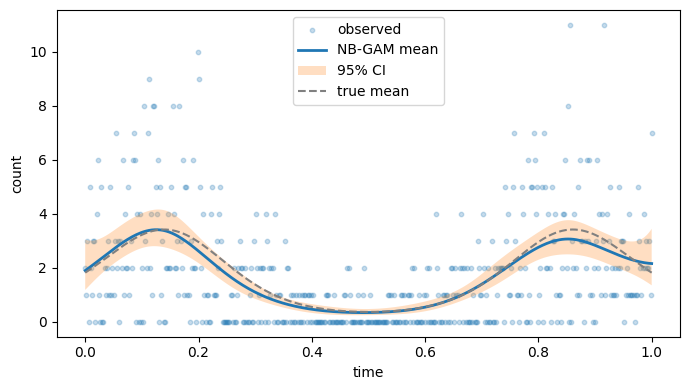

In [60]:
plt.figure(figsize=(7,4))
plt.scatter(dat["time"], dat["y"], s=10, alpha=0.25, label="observed")
plt.plot(new_dat["time"], mu_hat, lw=2, label="NB-GAM mean")
plt.fill_between(new_dat["time"], lower, upper, alpha=0.25, label="95% CI")
plt.plot(time, mu_true, "--", lw=1.5, color="gray", label="true mean")
plt.xlabel("time")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()